# Exercise 1: Maximum-likelihood fitting

In this exercise we will implement a maximum-likelihood fit using the common example of fitting a Gaussian curve to some normally-distributed data.

The main task will be to implement a gradient-descent algorithm.


## Parameters

The objective of fitting a PDF to data is to find the values of the PDF's parameters that maximise the likelihood, thus giving the best description of a dataset (i.e. the best fit).

While it's possible to store parameters as simple `float`s, we ask that you implement a class that stores the parameter value and a range that the value cannot stray outside during the fit. This will be especially helpful while testing and debugging your minimiser

## PDFs and likelihoods

A Gaussian PDF is defined as:
$$
f(x|\mu,\sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

The likelihood is the product of the PDF evaluated on all points $\{x_i\}$ in a dataset (assuming all points are independent):

$$
\mathcal{L}(\mu,\sigma) = \prod_i f(x_i|\mu,\sigma)
$$

Rather than maximise the likelihood, it is easier computationally to minimise the negative log-likelihood:
$$
-\log(\mathcal{L}(\mu,\sigma)) = -\sum_i\log(f(x_i|\mu,\sigma)) 
$$
with
$$
\log(\mathcal{L}(\mu,\sigma)) = \log\left(\frac{1}{\sigma\sqrt{2\pi}}\right) + \frac{1}{2\sigma^2} \sum_i \left(-(x_i-\mu)^2\right) =: -L(\mu, \sigma)
$$

In [54]:
def L(x, mu, sig):
    fac = np.log(1 / (np.sqrt(2*np.pi)*sig) )
    exp = np.sum((x-mu)**2) / (2*sig**2)
    return fac+exp

## Minimisation via gradient descent

Gradient descent is a method of finding the local minimum of a differentiable function by following the local gradient.

Note that the local minimum may not be the same as the global minimum. There are strategies to avoid a local-but-not-global minimum, such as performing a fit multiple times with random starting values.

Say we have a multivariate function $L(\vec{\theta})$, where $\vec{\theta} = [\theta_1, \theta_2, ..., \theta_n].$ _**NB**: in this exercise, $L(\vec{\theta})=-\log(\mathcal{L}(\mu,\sigma))$, the negative log-likelihood._

The gradient of the function is $$\nabla_\theta L(\vec{\theta}) = \left[\frac{\partial L}{\partial \theta_1}, \frac{\partial L}{\partial \theta_2}, ..., \frac{\partial L}{\partial \theta_n}\right].$$

Starting from some initial position $\vec{\theta}_i$, one can descend the gradient towards the minimum by subtracting an amount proportional to the local gradient: $$\vec{\theta}_{t} = \vec{\theta}_{t-1} - \eta_t \nabla_\theta L(\vec{\theta}_{t-1}),$$ where $\eta_t$ is the "step size". This can be repeated until $\vec{\theta}$ converges on the values that minimise $L(\vec{\theta})$ (i.e. the best-fit values $\vec{\hat{\theta}}$).

The exact criterion for achieving convergence is up to you to decide and implement.
A good starting point is to use the relative change $$\left|\frac{L(\vec{\theta}_{i})-L(\vec{\theta}_{i-1})}{L(\vec{\theta}_{i})+L(\vec{\theta}_{i-1})}\right|$$ and stop when it goes below some threshold.

Choosing an appropriate step size $\eta_t$ is crucial for an optimal balance between speed and precision, and many methods are available for doing this. Note that it does not need to be a fixed size and can be adjusted at each iteration.

### Batch vs stochastic

In batch gradient descent, the parameters are updated using the likelihood calculated over the full dataset.

In stochastic gradient descent, the parameters are updated for each datapoint (using $\nabla_\theta L(\vec{\theta}, x_i)$), or a sub-sample of the full dataset (mini-batch).

*See the lecture notes for more.*

### Momentum

Useful particularly in stochastic/mini-batch gradient descent is the idea of 'momentum'. Where the parameters are updated using: $$\vec{\theta}_t = \vec{\theta}_{t-1} - \vec{v}_t,$$ where $$\vec{v}_t = \gamma \vec{v}_{t-1} + \eta_t \nabla_\theta L(\vec{\theta}_{t-1}, x),$$ where $\gamma$ is the momentum parameter $0 < \gamma < 1$ (typically around 0.9).

### Nesterov's accelerated gradient descent

Using momentum we can 'look ahead' to where the next update will be approximately, without calculating a new gradient: $$\vec{\theta}_t \approx \vec{\theta}_{t-1} - \gamma \vec{v}_{t-1}$$

We can instead use that position when calculating the new gradient, so $\vec{v}_t$ becomes: $$\vec{v}_t = \gamma \vec{v}_{t-1} + \eta_t \nabla_\theta L(\vec{\theta}_{t-1} - \gamma \vec{v}_{t-1}, x).$$

## Implementing your own gradient-descent minimiser

Here you should implement:
1. A parameter class that holds the value and allowed range of a parameter
  - When setting a value outside the allowed range, force the value to equal the nearest boundary
2. A Gaussian PDF class or function using parameters that control its mean and standard deviation
3. A gradient-descent minimiser which iteratively:
  - Calcualtes the likelihood gradient at the current values of the fit parameters
  - Updates the parameters following the gradient
  - Saves the likelihood in a list (for plotting later)
  - Stops the fit if it has converged (or if a maximum number of iterations have been reached)

### Gradient function

In [131]:
def derivative(func, derive_dim, x, *args):
    # not perfect!!!
    import numpy as np
    eps = np.finfo(float).eps
    hi = np.array(args, dtype=float)
    lo = np.array(args, dtype=float)
    hi[derive_dim] *= (1+eps)
    lo[derive_dim] *= (1-eps)
    
    dv = ( func(x, *hi) - func(x, *lo) ) / (2*args[derive_dim]*eps)
    
    return dv
    

def gradient(func, x, *args):
    out = []
    # derive in every dimension
    for i in range(len(args)):
        out.append(derivative(func, i, x, *args))
    return out

def dummy(x, mu, sig):
    return (x-mu)**2/2/sig**2




In [200]:
# Implement the parameter class, the Guassian PDF and gradient-descent minimisation here
# You can create extra cells if you wish

import numpy as np

class param:
    def __init__(self, value, lower_limit, upper_limit):
        self.low = lower_limit
        self.up = upper_limit
        self.value = value
        return None
        
    def new_value(self, new_val):
        # including a range check
        if new_val < self.low:
            self.value = self.low
        elif new_val > self.up:
            self.value = self.up
        else:
            self.value = new_val
        return None
            
        
def gauss(x, mu, sig):
    return 1 / np.sqrt(2*np.pi*sig**2) * np.exp( -(x-mu)**2 / (2*sig**2) )


def gauss_fit(x, a, mu, sig):
    return a / np.sqrt(2*np.pi*sig**2) * np.exp( -(x-mu)**2 / (2*sig**2) )


# 3. A gradient-descent minimiser which iteratively:
  # - Calcualtes the likelihood gradient at the current values of the fit parameters
  # - Updates the parameters following the gradient
  # - Saves the likelihood in a list (for plotting later)
  # - Stops the fit if it has converged (or if a maximum number of iterations have been reached)



def gdMinimiser(data, eta=0.9, max_iter = 5e3):
    """
    maximise a function's log-likelihood (minimise chisq)
    using stochastic gradient descent (assumes normal distributed values)
    
    params:
    data : array of data points
    eta : learning rate
    
    """
    
    # mu0, sigma0 = data.mean(), data.std()
    # self.mu0 = mu0
    # self.sigma0 = sigma0

    # if mu would not lie in data, maybe to little values
    mu_min, mu_max = 0, data.max()*1e3 # data.min(), data.max()

    # not so sure yet, maybe mu_min, mu_max
    sigma_min, sigma_max = 0, data.std()*1e2 # mu_min, mu_max
    
    # define 't-1' parameters with small offset to 't'
    mu0  = param(data.mean() *1.2,  mu_min,  mu_max)
    sigma0 = param(data.std() *0.9, sigma_min, sigma_max)
    
    # define 't' parameters
    mu1  = param(data.mean()*1.1, mu_min, mu_max)
    sigma1 = param(data.std()*0.8, sigma_min, sigma_max)
    
    # Saves the likelihood in a list (for plotting later)
    lhood_list = []
    
    eta_mu = 2 # (mu1.value - mu0.value) / (mu1.value + mu0.value)
    eta_sigma = 2 # (sigma1.value - sigma0.value) / (sigma1.value + sigma0.value) 

    # start and handling params for while loop
    # Stops the fit if it has converged (or if a maximum number of iterations have been reached)
    break_criterion = 1e10
    n_iter = 0
    
    ###########
    mu_list, sigma_list = [], []
    
    while break_criterion > 1e-5 and n_iter < max_iter:
        
        lhood = L(data, mu1.value, sigma1.value)
                
        # save for plotting
        lhood_list.append(lhood)

        gradient_mu, gradient_sigma = gradient(L, data, mu1.value, sigma1.value)

        mu0.new_value(mu1.value)
        sigma0.new_value(sigma1.value)
        
        mu1.new_value(mu1.value - eta_mu * gradient_mu)
        sigma1.new_value(sigma1.value - eta_sigma * gradient_sigma)
        
        mu_list.append(mu1.value)
        sigma_list.append(np.sqrt(sigma1.value))
        
        break_criterion = np.abs(gradient_mu) + np.abs(gradient_sigma)
        
        n_iter += 1
        
#         print(n_iter, mu1.value, sigma1.value)
    if n_iter < max_iter:
        print(f"Converged after {n_iter} iterations!")
    # else:
    #     raise OptimizeWarning(f"Did not converge, maximum number of iterations ({max_iter}) reached.\nmu = {mu1.value}, sigma = {var1.value}")
   
    return [mu1.value, sigma1.value], lhood_list, mu_list, sigma_list
    

Converged after 42365 iterations!
[5300.6775474989645, 1433.805351852375]


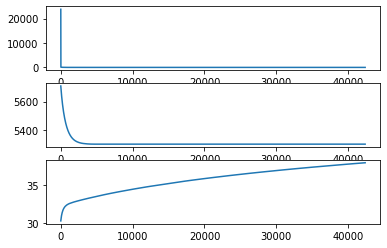

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("test_data.csv", names=["mass"])
data = df["mass"].to_numpy()


popt, lhoods, mus, sigs = gdMinimiser(data, eta=0.1, max_iter=5e4)

print(popt)

fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(lhoods)
ax2.plot(mus)
ax3.plot(sigs)
plt.show()

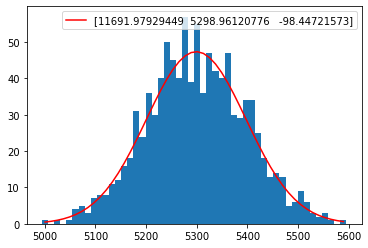

In [151]:
import scipy.optimize as so

num_bins = 50
vals, bins, _ = plt.hist(df["mass"], num_bins)
bin_width = (bins[-1] - bins[0])/num_bins

x = (bins[1:] + bins[:-1]) / 2
y = vals
y_err = vals
y_err[y_err == 0] = 1
y_err = np.sqrt( y_err )

popt, pcov = so.curve_fit(gauss_fit, x, y, sigma=y_err, p0=[1, data.mean(), data.std()])

plt.plot(x, gauss_fit(x, *popt), c='r', label=popt)
plt.legend()
plt.show()

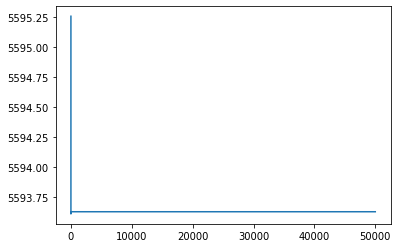

In [53]:
plt.plot(mus)

## Fitting data

The data sample provided with this sheet consists of Gaussian-distributed measurements of the $B^0$ meson mass, in units of MeV. The standard deviation of the distribution is dominated by the resolution of the detector used to make the measurement.

Your task is to obtain best-fit values for the mass of the meson (i.e. the mean, $\mu$) and the detector resolution (i.e. the standard deviation $\sigma$) using your minimiser and Gaussian PDFs implemented above.

In the cell below, the data is loaded into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and plotted as a [Matplotlib histogram](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). This should give you an idea of which starting values and ranges to set for the parameters.

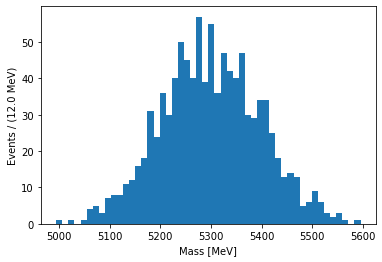

In [200]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("test_data.csv", names=["mass"])

num_bins = 50
vals, bins, _ = plt.hist(df["mass"], num_bins)
bin_width = (bins[-1] - bins[0])/num_bins
plt.xlabel("Mass [MeV]")
plt.ylabel(f"Events / ({bin_width:.1f} MeV)")
plt.show()

In [202]:
# Use this cell to perform a fit to the data


## Plotting the results

1. Plot the PDF with best-fit values overlaid on to a histogram of the data.
  - _**Hint**: to achieve the same normalisation for the data and the PDF, you may choose to use `density=True` in the arguments to `pyplot.hist`_
1. Plot a 'likelihood trace' (i.e. the 'history' of the likelihood at each iteration) for the following cases:
  - Several choices of fixed step size for batch gradient descent
  - The effect of different methods of gradient-descent (6 in total)
    - batch
    - mini-batch
    - stochastic
    - all of the above using the Nesterov technique